# Climate Risk Index Based on Keyword Frequency Technique

## 1. Idea

Climate risk assessment typically requires collecting information from multiple dimensions (e.g., keyword frequency, sentiment orientation), and these dimensions often have different scales and levels of importance.

The frequency of keyword occurrences can reflect the level of attention given to specific risk indicators (such as “flood” or “carbon emissions”) in the text. A higher frequency may indicate greater emphasis on the risk, making it an important signal for climate risk assessment.

## 2. Dateset

Download the 10-Q filing of NextEra Energy, Inc. (NEE), one of the largest renewable energy companies in the United States. In its 10-Q report, NextEra Energy may mention keywords such as “renewable energy,” “solar power,” “wind power,” “energy transition,” and “emission reduction target.” The company actively invests in low-carbon technologies and may disclose risks related to climate policies, such as “carbon pricing” or “climate regulation.”

We can develop code to automatically retrieve such filings from the [*SEC's EDGAR database*](https://www.sec.gov/edgar/), where reports are typically available in HTML format.

<img src='images/EDGAR.png' width=300> <img src='images/NEE-10-Q.png'  width=300>

## 3. Implementation

### 3.1 Extract text from HTML file

We can implement a function like `extract_text_from_html(html_path)` to read an HTML file using UTF-8 encoding, parse it with BeautifulSoup, extract readable text by removing tags and whitespace, handle errors, and return the text as a string—streamlining report content analysis.

In [1]:
from bs4 import BeautifulSoup
def extract_text_from_html(html_path):
    text = ""
    try:
        # Read the HTML file
        with open(html_path, 'r', encoding='utf-8') as file:
            soup = BeautifulSoup(file, 'html.parser')
            text = soup.get_text(separator=' ', strip=True)
    except Exception as e:
        print(f"Error reading HTML: {e}")
    return text

### 3.2 Keyword frequency counting

In [2]:
climate_keywords = {
    "Extreme Weather Risk Index": 
                    ["flood", "hurricane",
                     "drought","extreme heat", "storm"],
    "Greenhouse Gas Emission\n Intensity Index": 
                    ["carbon emission", "greenhouse gas",
                    "emission intensity", "carbon dioxide",
                    "emission reduction target"],
    "Climate Adaptability and\n Resilience Index": 
                    ["climate resilience",
                    "infrastructure upgrade",
                    "emergency plan",
                    "climate adaptation",
                    "adaptation plan"],
    "Renewable Energy Investment\n and Transition Progress Index": 
                    ["renewable energy","solar power",
                     "wind power", "low-carbon technology",
                     "energy transition"],
    "Policy and Legal Risk Index": 
                    ["carbon tax", "emission trading",
                     "climate regulation", "policy uncertainty",
                     "carbon pricing"]
}

Given that these keywords individually appear infrequently in each quarterly report, combining them provides a more comprehensive reflection of climate-related risks, adaptability, policy impacts, and the energy transition process. This can be summarized as the **Comprehensive Climate Risk and Adaptability Index (CCRA Index)**.

The CCRA Index serves as a metric for assessing a company’s overall performance in climate-related areas, incorporating both risk factors and response strategies, including policy considerations.

In [3]:
climate_keywords['Comprehensive Climate Risk\n and Adaptability Index'] = [
    "flood", "hurricane", "drought", "extreme heat", "storm",
    "carbon emission", "greenhouse gas", "emission intensity",
    "carbon dioxide", "emission reduction target", "climate resilience",
    "infrastructure upgrade", "emergency plan", "climate adaptation",
    "adaptation plan", "renewable energy", "solar power", "wind power",
    "low-carbon technology", "energy transition", "carbon tax",
    "emission trading", "climate regulation", "policy uncertainty",
    "carbon pricing"
]

This function, `extract_keywords(text, keywords_dict)`, takes a text string and a dictionary of keywords, converts the text to lowercase, and counts the occurrences of each keyword (case-insensitive) within the text using regular expressions, returning a dictionary of keyword counts organized by indicator.

In [4]:
import re
from collections import Counter

def extract_keywords(text, keywords_dict):
    text = text.lower()  
    keyword_counts = {}
    
    for indicator, keywords in keywords_dict.items():
        counts = Counter()
        for keyword in keywords:
            keyword = keyword.lower()
            counts[keyword] = len(re.findall(r'\b' + re.escape(keyword) + r'\b', text))
        keyword_counts[indicator] = counts
    return keyword_counts

### 3.3 Quantify indicators

In [5]:
def quantify_indicators(keyword_counts, text,
                        weight_keywords=0.7, weight_sentiment=0.3):
    indicators = {}
    for indicator, counts in keyword_counts.items():
        total_mentions = sum(counts.values())
        indicators[indicator] = total_mentions 
    return indicators

### 3.4 Visualize indicators

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 

def plot_indicators(indicators, title, figsize=(6,4)):
    df = pd.DataFrame.from_dict(indicators, orient='index',
                                columns=['Score'])
    #df = df.sort_values(by='Score', ascending=False)
    plt.figure(figsize=figsize)
    sns.barplot(x=df.index, y='Score', data=df,
                palette='viridis', hue=df.index, legend=False)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.xlabel('Date')
    plt.title(title)
    plt.tight_layout()
    plt.show()

### 3.5 Exact date from 10-Q

In [7]:
def extract_10_Q_date(text):
    date = text.split('For the quarterly period ended ')[-1].split(' Commission File')[0].split(' OR ')[0]
    return date

### 3.6 Main function: Process a single report

In [8]:
from tqdm.notebook import tqdm
import time
def process_report(html_path):
    with tqdm(total=4, desc=f"{html_path.split('/')[-1]}",
              bar_format="{l_bar}{unit}{bar}",
            unit="", disable=True) as pbar:
        
        # Step 1 Extracting HTML text
        text = extract_text_from_html(html_path)
        if not text:
            print("No text extracted from the HTML.")
            return
        pbar.update(1)
        
        # Step 2 Extracting keyword counts
        climate_keyword_counts = extract_keywords(text, climate_keywords)
        pbar.update(1)
        
        # Step 3 Quantifying climate indicators
        climate_indicators = quantify_indicators(climate_keyword_counts, text)
        pbar.update(1)
        
        # Step 4 Extracting date
        date = extract_10_Q_date(text)
        pbar.update(1)
    return date, climate_indicators

## 4. Test

In [9]:
html_path = "datasets/sec-edgar-filings/NEE/10-Q-htm/full-submission-0000753308-24-000057.htm"  
date, climate_indicators = process_report(html_path)

In [10]:
climate_indicators

{'Extreme Weather Risk Index': 158,
 'Greenhouse Gas Emission\n Intensity Index': 1,
 'Climate Adaptability and\n Resilience Index': 0,
 'Renewable Energy Investment\n and Transition Progress Index': 37,
 'Policy and Legal Risk Index': 0,
 'Comprehensive Climate Risk\n and Adaptability Index': 196}

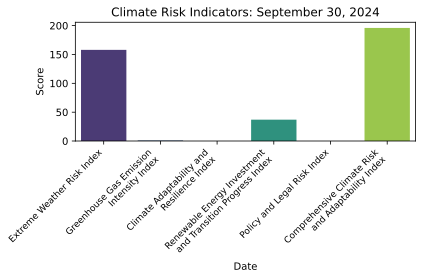

In [11]:
plot_indicators(climate_indicators, f"Climate Risk Indicators: {date}")

These keyword frequencies reflect the level of attention given to various climate risk-related indices in the report. For example, the higher frequencies of the Extreme Weather Risk Index and Comprehensive Climate Risk and Adaptability Index indicate that these indices are discussed more extensively in the text. In contrast, the lower frequencies of the Greenhouse Gas Emission Intensity Index and Policy and Legal Risk Index suggest that they are less emphasized in the report. The zero frequency of the Climate Adaptability and Resilience Index indicates that this index was not mentioned at all in the text.

## 5. Comprehensive Climate Risk and Adaptability Index

In [18]:
import os

path = 'datasets/sec-edgar-filings/NEE/10-Q-htm/'
l = os.listdir(path)
l.sort()
EWR, GGEI, CAR, PEITP, PLR, CCRA = {}, {}, {}, {}, {}, {}

for i in tqdm(l, desc="Processing files", unit="file"):
    if 'full' not in i: continue
    html_path = os.path.join(path, i)
    date, climate_indicators = process_report(html_path)
    CCRA[date] = climate_indicators['Comprehensive Climate Risk\n and Adaptability Index']

Processing files:   0%|          | 0/30 [00:00<?, ?file/s]

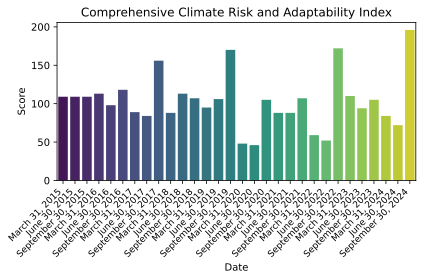

In [20]:
plot_indicators(CCRA, "Comprehensive Climate Risk and Adaptability Index", (6,4))

Observing the figure above, it can be seen that NEE disclosed fewer climate risk-related keywords in its 10-Q filings for March and June each year from 2020 to 2024. This resulted in a periodic decline in the comprehensive index. This is an interesting finding.

## 6. Disadvantages of Keyword Frequency Technique

In individual quarterly 10-Q filings, some indices have a value of zero due to the absence of matched keywords, while others contain numerical values. This highlights a limitation of the keyword-based indexing approach—when synonymous terms or contextually equivalent phrases are used instead of predefined keywords, they may not be captured, leading to distortions in the index.

To mitigate this issue, advanced natural language processing (NLP) techniques, such as semantic similarity models or contextual embeddings, could be integrated to enhance keyword recognition and improve the accuracy of climate-related indices.

Of course, a more effective approach is to use pre-trained models such as BERT and GPT. These AI and deep learning-based technologies have been proven to excel in text comprehension and reasoning. By leveraging their semantic understanding capabilities, relevant content can be identified more accurately, reducing index distortion caused by keyword matching limitations and enhancing the reliability and effectiveness of climate-related indices.